In [1]:
import tensorflow as tf
import numpy as np

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

In [3]:
y_train_odd = list()
for y in y_train:
    if y % 2 == 0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)
y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [4]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [5]:
y_valid_odd = list()
for y in y_valid:
    if y % 2 == 0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)
y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [6]:
x_train = x_train / 255.
x_valid = x_valid / 255.
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)
print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# 입력에 대한 출력을 2개로 나누는 모델
inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 5408)         0           max_pooling2d[0][0]              
_______________________________________________________________________________________

In [8]:
# !pip install pydot

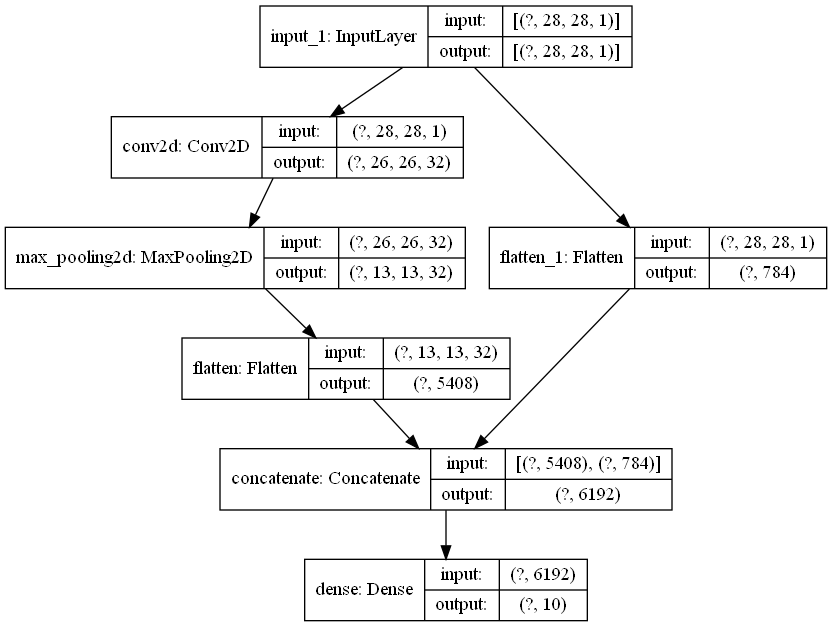

In [9]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1979 - accuracy: 0.9444 - val_loss: 0.0893 - val_accuracy: 0.9722
Epoch 2/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0763 - accuracy: 0.9773 - val_loss: 0.0622 - val_accuracy: 0.9800
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.0578 - val_accuracy: 0.9807
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0572 - val_accuracy: 0.9810
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.0573 - val_accuracy: 0.9817


In [14]:
# 출력 레이어를 2개로 출력
# - 출력 1: 0-9 숫자 예측
# - 출력 2: 홀수, 짝수 예측

inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_layer (Conv2D)           (None, 26, 26, 32)   320         inputs[0][0]                     
__________________________________________________________________________________________________
maxpool_layer (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d_layer[0][0]               
__________________________________________________________________________________________________
flatten_layer (Flatten)         (None, 5408)         0           maxpool_layer[0][0]              
_______________________________________________________________________________________

In [15]:
print(model.input)
print(model.output)

Tensor("inputs_2:0", shape=(None, 28, 28, 1), dtype=float32)
[<tf.Tensor 'digit_dense/Softmax_2:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'odd_dense/Sigmoid_1:0' shape=(None, 1) dtype=float32>]


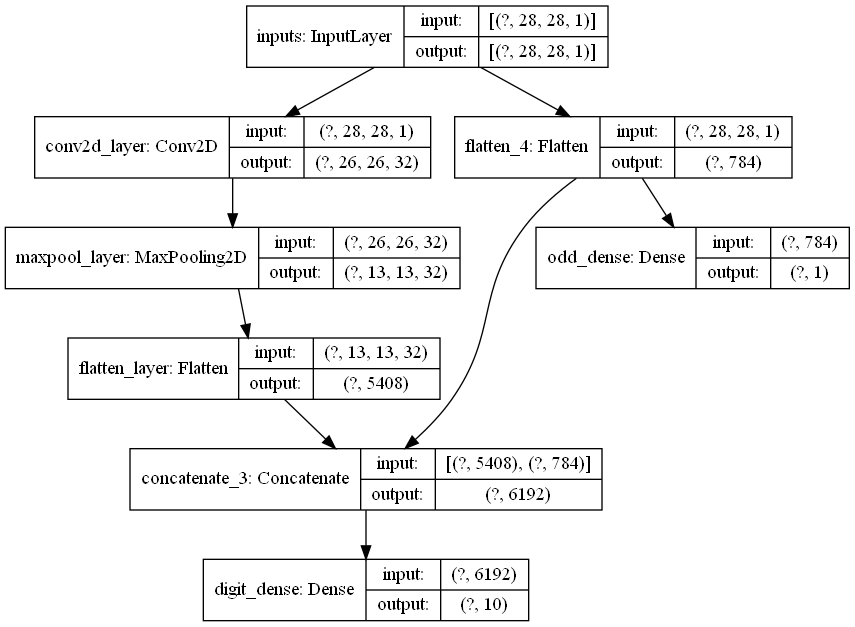

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_outputs_cnn.png')

In [17]:
model.compile(optimizer='adam',
             loss={'digit_dense':'sparse_categorical_crossentropy', 'odd_dense':'binary_crossentropy'},
             loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 * sparse_categorical_crossentropy + 0.5 * binary_crossentropy
             metrics=['accuracy']
             )

In [18]:
history = model.fit({'inputs':x_train_in}, {'digit_dense':y_train, 'odd_dense':y_train_odd},
                   validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd}),
                   epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3617 - digit_dense_loss: 0.2000 - odd_dense_loss: 0.3234 - digit_dense_accuracy: 0.9436 - odd_dense_accuracy: 0.8650 - val_loss: 0.2226 - val_digit_dense_loss: 0.0842 - val_odd_dense_loss: 0.2767 - val_digit_dense_accuracy: 0.9750 - val_odd_dense_accuracy: 0.8860
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2173 - digit_dense_loss: 0.0815 - odd_dense_loss: 0.2717 - digit_dense_accuracy: 0.9762 - odd_dense_accuracy: 0.8905 - val_loss: 0.1982 - val_digit_dense_loss: 0.0671 - val_odd_dense_loss: 0.2623 - val_digit_dense_accuracy: 0.9794 - val_odd_dense_accuracy: 0.8983
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1923 - digit_dense_loss: 0.0610 - odd_dense_loss: 0.2627 - digit_dense_accuracy: 0.9816 - odd_dense_accuracy: 0.8954 - val_loss: 0.1954 - val_digit_dense_loss: 0.0662 - val_odd_dense_loss: 0.2585 - val_digit_dense_accuracy: 0.9782 - va

In [19]:
model.evaluate({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd})

313/313 [==============================] - 1s 3ms/step - loss: 0.1924 - digit_dense_loss: 0.0649 - odd_dense_loss: 0.2549 - digit_dense_accuracy: 0.9818 - odd_dense_accuracy: 0.9018


[0.19235347211360931,
 0.06489433348178864,
 0.2549183666706085,
 0.9818000197410583,
 0.9017999768257141]

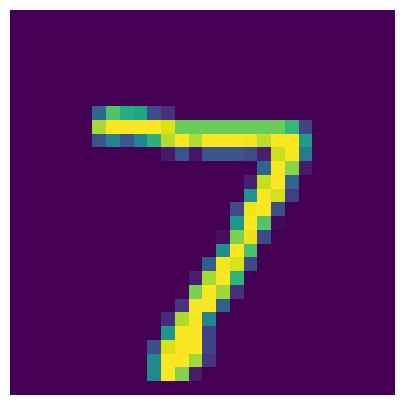

In [20]:
import matplotlib.pyplot as plt
def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis('off')
    plt.show()
plot_image(x_valid, 0)

In [21]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

[3.6610207e-12 8.5574409e-10 1.7541656e-09 4.8415825e-07 2.4816349e-12
 3.1616725e-12 1.7028628e-21 9.9999952e-01 1.7267063e-09 1.7608473e-08]
[0.99956894]


In [22]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [26]:
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[:10]

<ipython-input-26-f7900df06a39>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

In [27]:
# 숫자 분류하는 모델을 재구성 (Transfer learning)
base_model_outputs = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_outputs, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


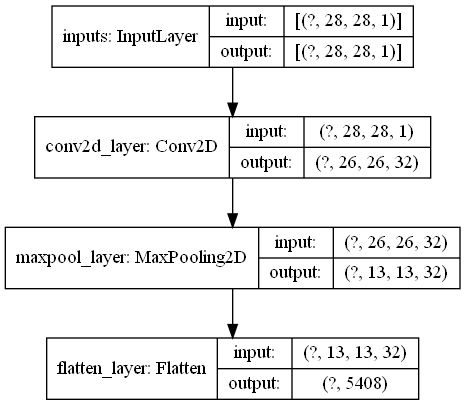

In [28]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [29]:
digit_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(10, activation='softmax'),
])
digit_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (Functional)            (None, 5408)              320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


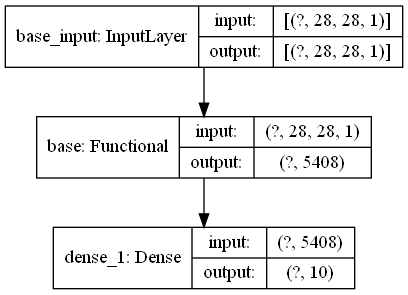

In [30]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [32]:
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1285 - accuracy: 0.9641 - val_loss: 0.0610 - val_accuracy: 0.9801
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0578 - accuracy: 0.9825 - val_loss: 0.0525 - val_accuracy: 0.9814
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0454 - accuracy: 0.9865 - val_loss: 0.0474 - val_accuracy: 0.9850
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0359 - accuracy: 0.9888 - val_loss: 0.0547 - val_accuracy: 0.9832
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0468 - val_accuracy: 0.9845
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0545 - val_accuracy: 0.9832
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0550 - val_ac

In [35]:
# 베이스 모델의 가중치를 고정(Freeze Model)
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model.output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [36]:
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_________________________________________________________________


In [37]:
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = digit_model_frozen.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1175 - accuracy: 0.9672 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0531 - val_accuracy: 0.9831
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0508 - val_accuracy: 0.9841
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0486 - val_accuracy: 0.9842
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.0567 - val_accuracy: 0.9822
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0191 - accuracy: 0.9942 - val_loss: 0.0535 - val_accuracy: 0.9834
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.0539 - val_accuracy:

In [38]:
# Conv2D 레이어의 가중치만 고정
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model.output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [39]:
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_________________________________________________________________


In [40]:
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = digit_model_frozen2.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1161 - accuracy: 0.9687 - val_loss: 0.0565 - val_accuracy: 0.9818
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0492 - accuracy: 0.9848 - val_loss: 0.0486 - val_accuracy: 0.9841
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0372 - accuracy: 0.9886 - val_loss: 0.0494 - val_accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.0567 - val_accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0228 - accuracy: 0.9934 - val_loss: 0.0509 - val_accuracy: 0.9842
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0568 - val_accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0582 - val_accuracy: